In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import numpy as np

# Tiền xử lí dữ liệu
- Loại dữ liệu từ csv
- is null
- duplicate
- outlier

In [2]:
estate_data = pd.read_csv('data/vietnam_housing_dataset.csv')

In [3]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


In [4]:
estate_data['Address_clean'] = (
    estate_data['Address']
    .str.lower()
    .str.replace('thành phố ', '', regex=False)
    .str.replace('tp. ', '', regex=False)
    .str.replace('tp ', '', regex=False)
    .str.replace('tỉnh ', '', regex=False)
)

address_parts = estate_data['Address_clean'].str.rsplit(',', n=2, expand=True)

estate_data['province_city'] = address_parts[2].str.strip()
estate_data['province_city'] = address_parts[2].fillna('Unknown')


In [5]:
estate_data = estate_data.drop(['Balcony direction', 'House direction', 'Furniture state', 'Access Road', 'Address', 'Address_clean'], axis=1)

In [6]:
estate_data['Frontage_missing'] = estate_data['Frontage'].isna().astype(int)
median_frontage = estate_data['Frontage'].median()
estate_data['Frontage'] = estate_data['Frontage'].fillna(median_frontage)

estate_data['Floors'] = estate_data['Floors'].fillna(estate_data['Floors'].mode()[0])

estate_data['Bedrooms'] = estate_data['Bedrooms'].fillna(estate_data['Bedrooms'].mode()[0])

estate_data['Bathrooms'] = estate_data['Bathrooms'].fillna(estate_data['Bathrooms'].mode()[0])

estate_data['Legal status'] = estate_data['Legal status'].fillna('Unknown')

In [41]:
estate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,30229.0,68.498741,48.069835,3.1,40.0,56.0,80.0,595.0
Frontage,30229.0,5.032055,3.440693,1.0,4.0,4.5,5.0,77.0
Floors,30229.0,3.480697,1.261732,1.0,2.0,4.0,4.0,10.0
Bedrooms,30229.0,3.423765,1.207520,1.0,3.0,3.0,4.0,9.0
Bathrooms,30229.0,3.265672,1.234208,1.0,3.0,3.0,4.0,9.0
Price,30229.0,5.872078,2.211877,1.0,4.2,5.9,7.5,11.5
Frontage_missing,30229.0,0.382547,0.486017,0.0,0.0,0.0,1.0,1.0


In [7]:
cap_area = estate_data['Area'].quantile(0.95)
estate_data['Area'] = estate_data['Area'].clip(upper=cap_area)

In [8]:
cap_frontage = estate_data['Frontage'].quantile(0.95)
estate_data['Frontage'] = estate_data['Frontage'].clip(upper=cap_frontage)

In [9]:
estate_data.duplicated()
estate_data = estate_data.drop_duplicates()
estate_data.shape

(28770, 9)

In [10]:
legal_dummies = pd.get_dummies(estate_data['Legal status'], prefix='legal', drop_first=True)
province_dummies = pd.get_dummies(estate_data['province_city'], prefix='prov', drop_first=True)

In [11]:
estate_data['log_area'] = np.log(estate_data['Area'])

estate_data['log_price'] = np.log(estate_data['Price'])

# Phân tích mối quan hệ của các thuộc tính
- heatmap
- biểu đồ (cột/đường/top) -> sau mỗi biểu đồ cần 1 kết luận

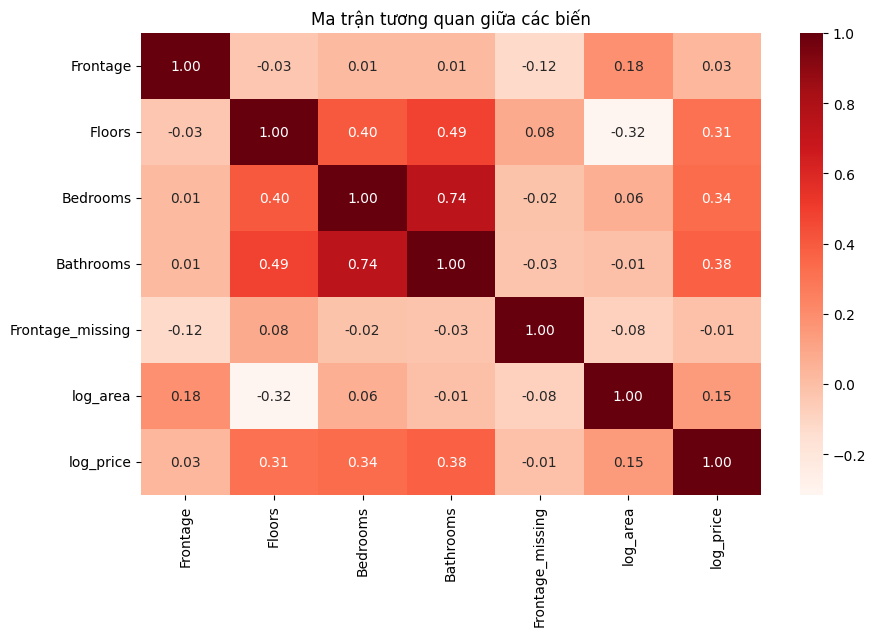

In [46]:
correlations_df = estate_data.drop(['Area', 'Price', 'Legal status', 'province_city'], axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(correlations_df.corr(), annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.title("Ma trận tương quan giữa các biến")
plt.show()

- Nhà có nhiều phòng ngủ thường cũng có nhiều phòng tắm -> tương quan Bathrooms và Bedrooms cao


In [50]:
top_5_province = estate_data["province_city"].value_counts().head(5)
others_count = pd.Series([len(estate_data["province_city"]) - top_5_province.sum()], index=["Others"])

Text(0.5, 1.0, 'Province')

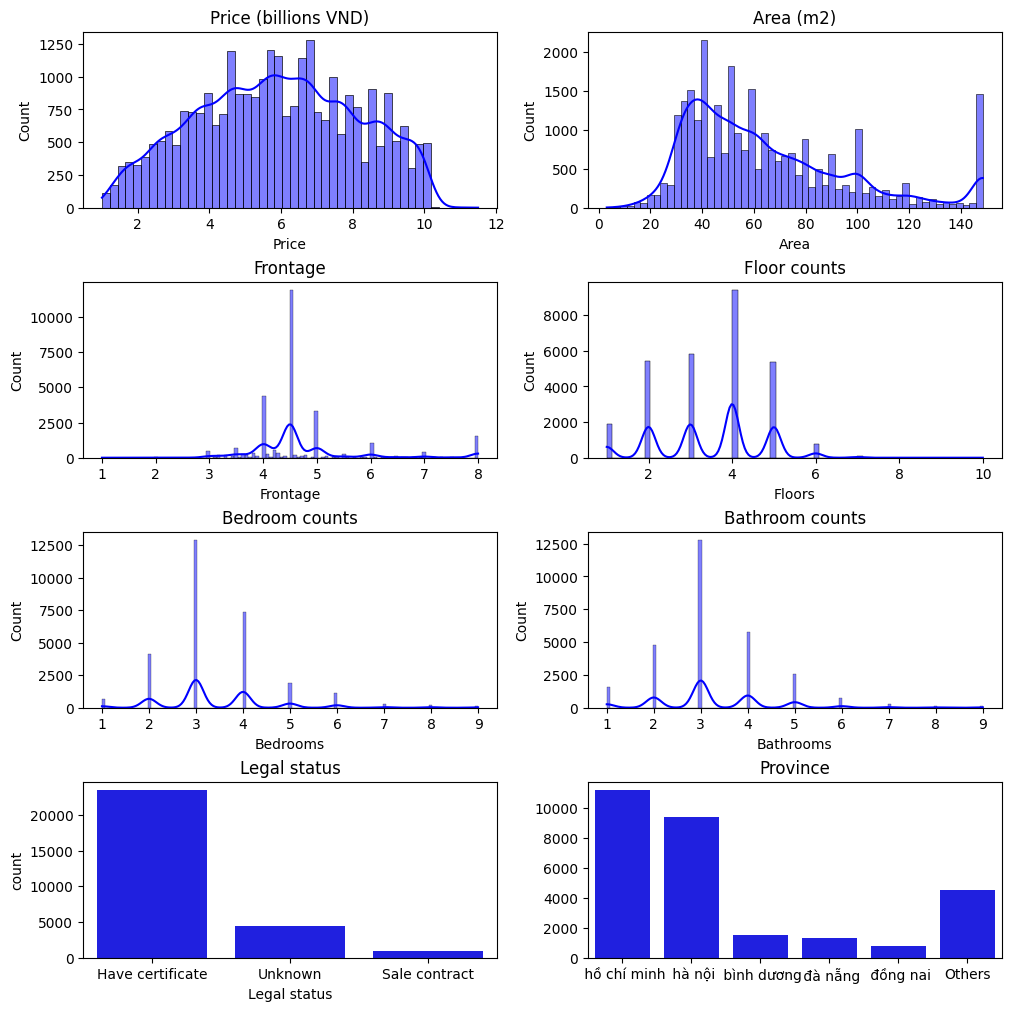

In [ ]:
fig, axis = plt.subplots(4, 2, figsize=(10, 10), layout="constrained")
plt.title("Distribution")

sns.histplot(data=estate_data, x=estate_data['Price'], kde=True, color='blue', ax=axis[0,0]).set_title("Price (billions VND)")
sns.histplot(data=estate_data, x=estate_data['Area'], kde=True, color='blue', ax=axis[0,1]).set_title("Area (m2)")
sns.histplot(data=estate_data, x=estate_data['Frontage'], kde=True, color='blue', ax=axis[1,0]).set_title("Frontage")
sns.histplot(data=estate_data, x=estate_data['Floors'], kde=True, color='blue', ax=axis[1,1]).set_title("Floor counts")
sns.histplot(data=estate_data, x=estate_data['Bedrooms'], kde=True, color='blue', ax=axis[2,0]).set_title("Bedroom counts")
sns.histplot(data=estate_data, x=estate_data['Bathrooms'], kde=True, color='blue', ax=axis[2,1]).set_title("Bathroom counts")
sns.countplot(data=estate_data, x=estate_data['Legal status'], ax=axis[3, 0], color='blue').set_title("Legal status")
sns.barplot(data=pd.concat([top_5_province, others_count]), ax=axis[3, 1], color='blue').set_title("Province")

- Phân phối giá nhà, diện tích bị lệch -> sử dụng log-transform để làm phân phối cân đối hơn và phù hợp

In [13]:
features = list(estate_data.select_dtypes(include='number').columns)

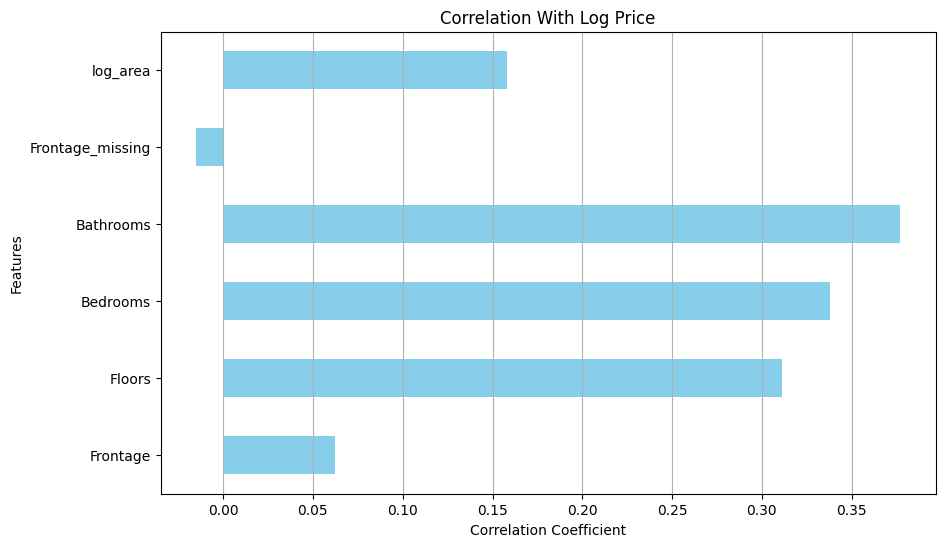

In [14]:
correlations = estate_data[features].corr()['log_price'].drop(['Price', 'Area', 'log_price'])

plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlation With Log Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

- Các biến liên quan đến quy mô và tiện nghi có tương quan dương với giá nhà, tuy nhiên mức độ không quá cao, cho thấy giá nhà phụ thuộc vào nhiều yếu tố kết hợp.

# Train - test - prediction
- Tạo mô hình
- Chia tập train - test
- Train (fit)
- Đánh giá mô hình với R^2 + MSE với tập test
- Dự đoán (có thể vẽ mô hình)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_numeric = estate_data[['log_area', 'Frontage', 'Floors', 'Bedrooms', 'Bathrooms', 'Frontage_missing']]
X = pd.concat([X_numeric, legal_dummies, province_dummies], axis=1)
y = estate_data['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# initialize model
model = LinearRegression()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate model's performance
def evaluate_performance(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print('Mean Absolute Error: ', mae)
    print('Mean Squared Error: ', mse)
    print('Root Mean Squared Error: ', rmse)
    print('R2 Score: ', r2)

    
evaluate_performance(y_test, y_pred)

Mean Absolute Error:  0.26682170243803377
Mean Squared Error:  0.12322508130208101
Root Mean Squared Error:  0.3510343021729942
R2 Score:  0.3987388660941681


- Giá trị R² cho thấy mô hình giải thích được ~40% sự biến thiên của giá nhà -> phù hợp với đặc thù dữ liệu bất động sản vốn chịu ảnh hưởng bởi nhiều yếu tố khó đo lường

In [29]:
comparison = pd.DataFrame({"Thực tế:": y_test, "Dự đoán": y_pred})
print(comparison.head())

       Thực tế:   Dự đoán
29131  1.708378  1.858411
14270  1.704748  1.954976
13087  2.302585  2.021695
7977   1.757858  1.592748
23512  1.648659  1.773330


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


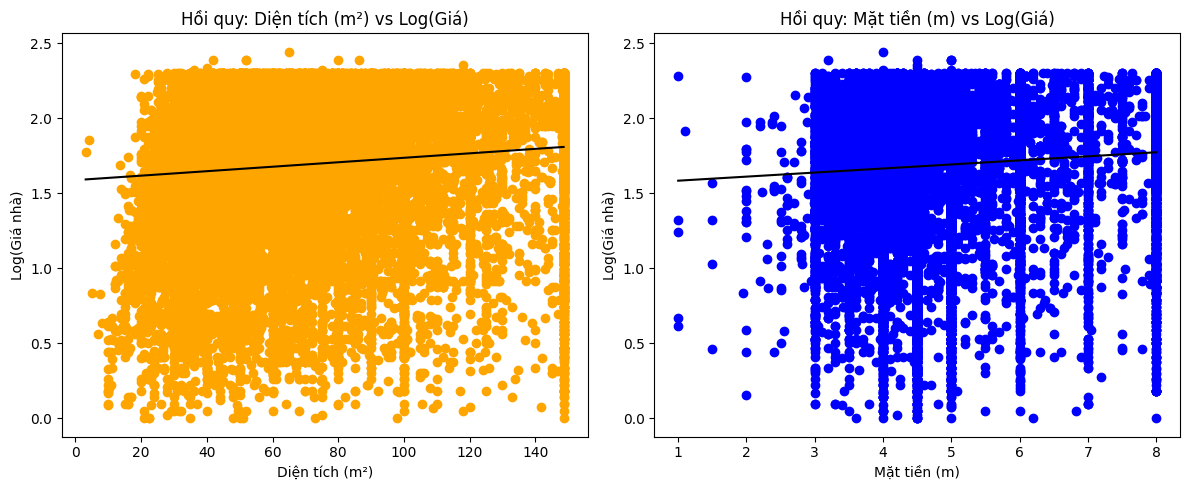

In [34]:
features_plot = [('Area', 'Diện tích (m²)'), ('Frontage', 'Mặt tiền (m)')]
colors_plot = ['orange', 'blue']

y_log = np.log(estate_data['Price'])

fig, axes = plt.subplots(1, len(features_plot), figsize=(6 * len(features_plot), 5))

for ax, (feature, xlabel), color in zip(axes, features_plot, colors_plot):
    
    X = estate_data[[feature]]
    
    lr = LinearRegression()
    lr.fit(X, y_log)
    
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = lr.predict(x_line)
    
    ax.scatter(estate_data[feature], y_log, color=color)
    ax.plot(x_line, y_line, color='black')
    
    ax.set_title(f"Hồi quy: {xlabel} vs Log(Giá)")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Log(Giá nhà)")

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_14284\1465690570.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14284\1465690570.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14284\1465690570.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True)


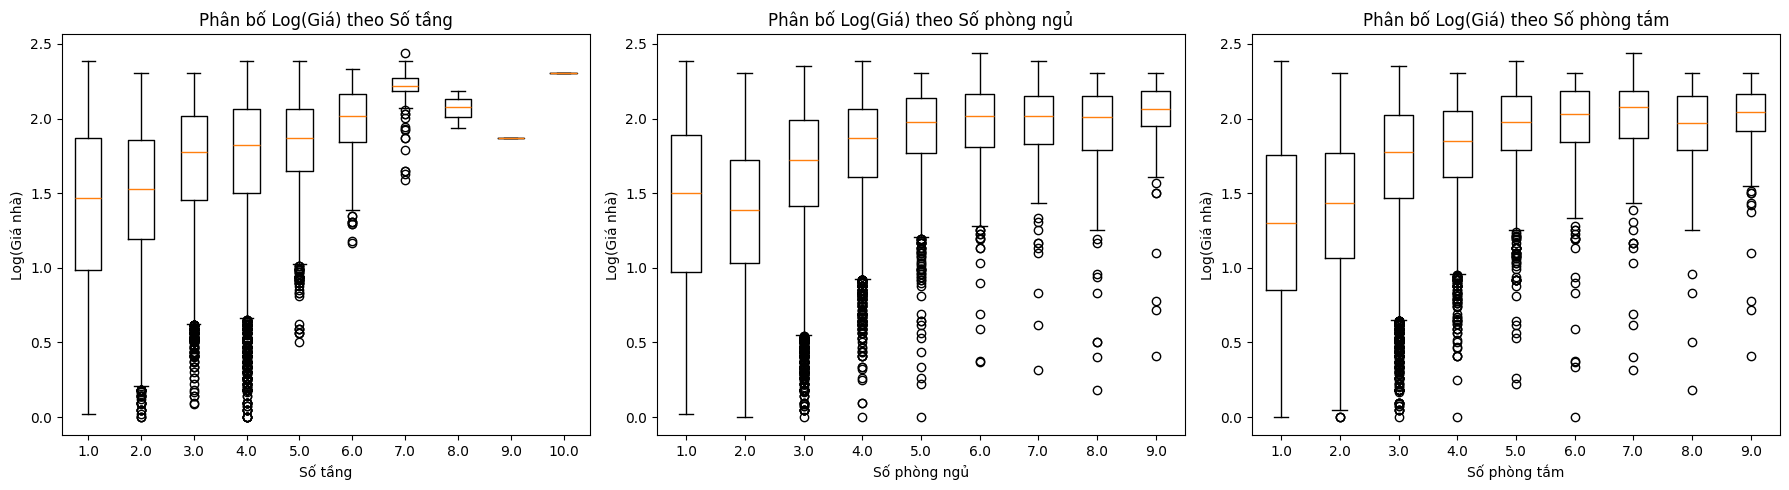

In [ ]:
box_features = [('Floors', 'Số tầng'), ('Bedrooms', 'Số phòng ngủ'), ('Bathrooms', 'Số phòng tắm')]
fig, axes = plt.subplots(1, len(box_features), figsize=(6 * len(box_features), 5))

for ax, (feature, xlabel) in zip(axes, box_features):
    
    data = [
        y_log[estate_data[feature] == val]
        for val in sorted(estate_data[feature].dropna().unique())
    ]
    
    labels = sorted(estate_data[feature].dropna().unique())
    
    ax.boxplot(data, labels=labels, showfliers=True)
    
    ax.set_title(f"Phân bố Log(Giá) theo {xlabel}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Log(Giá nhà)")

plt.tight_layout()
plt.show()